In [1]:
#This module constructs and performs monthly rebalancing for portfolio consisting of NASDAQ 100, BTC and ETH based on maximum sharp ratio and minimum variance optimization.
#Backtest period is from 2018-01-01 to 2023-12-31. and rolling previous 24 month has been taken as sample. Mean return is used as expected return,
#And previous 24month covariance matrix is used as expected covariance matrix.
#Few tools from EDHEC-Portfolio construction coursera course has been referred.

import yfinance as yf
from scipy.optimize import minimize
import pandas as pd
import numpy as np

In [3]:
def portfolio_return(weights:np.array, returns:np.array) -> float:
    """
    Calculate portfolio's return based on weight and return provided
    """
    return weights.T @ returns

def portfolio_vol(weights:np.array, cov_matrix:pd.DataFrame) -> float:
    """
    Calculate portfolio's vol based on weight and volatility provided
    """
    return (weights.T @ cov_matrix @ weights)**0.5



def min_variance(cov_matrix:pd.DataFrame) -> np.array:
    """
    Use optimizor to get the weights that have minimum volotility
    """
    n = cov_matrix.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}
    
    
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov_matrix,), method='SLSQP',
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


def max_sharp(expected_return:np.array, cov_matrix:pd.DataFrame) ->np.array:
    """
    Use optimizor to get the weights that have maximum volotility
    """
    n = cov_matrix.shape[0]
    risk_free = 0.03
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}
    
    def reciprocal_sharpe(weights: np.array, expected_return: np.array, cov_matrix: pd.DataFrame) -> float:
        """
        Returns the 1/sharp ratio, so it can be used in minimizor
        """
        return portfolio_vol(weights, cov_matrix)/(portfolio_return(weights, expected_return)-risk_free)
    
    
    weights = minimize(reciprocal_sharpe, init_guess,
                       args=(expected_return,cov_matrix), method='SLSQP',
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


In [5]:
#Download daily price for nasdaq,btc,eth since 2016-01-01 and forwardfill the NDX price in weekends.
price=yf.download(["^NDX","BTC-USD","ETH-USD"],'2016-01-01')['Adj Close']
price=price.fillna(method='ffill')
#Calculate daily return and monthly return.
daily_return = price.pct_change().loc['2016-01-01':]
monthly_return = daily_return.resample('M').apply(lambda x: (x + 1).prod() - 1)

[*********************100%%**********************]  3 of 3 completed


C:\Users\Administrator\AppData\Local\Temp\ipykernel_29196\3330039849.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price=price.fillna(method='ffill')


In [7]:
#Run optimizor to get minimum variance weights and maximum sharp ratio weights each month for rebalancing.
#Sample period is 24month. Mean return over sample period is used as expected return. 24month covariance matrix is used as expected covariance matrix.
#The first rebalance happens on 2018-01-01 and the sample is 2016-01-01 to 2017-12-31. And the next sample is 2016-02-01 - 2018-01-31
#rebalance target weights each month were added into empty list created.


weights_min_var=[]
weights_max_sharp=[]
steps=monthly_return.loc['2018-01-01':'2023-12-31'].shape[0]

for i in range(0,steps):
    weights_min_var=[]
    weights_max_sharp=[]
    past_sample = monthly_return.iloc[i:i+24,]
    cov_matrix = past_sample.cov()
    expected_return = past_sample.mean()
   
    weights_min_var.append(min_variance(cov_matrix))
    
    weights_max_sharp.append(max_sharp(expected_return, cov_matrix))


In [9]:
#Create dataframe with the weights created. Matching the format with monthly return for calculation.
min_var_allocation=pd.DataFrame(data=weights_min_var,index=monthly_return.loc['2018-01-01':'2023-12-31'].index, columns=monthly_return.loc['2018-01-01':].columns)
max_sharp_allocation=pd.DataFrame(data=weights_max_sharp,index=monthly_return.loc['2018-01-01':'2023-12-31'].index, columns=monthly_return.loc['2018-01-01':].columns)

In [11]:
#Calculate Cummulative value of each strategy for plotting.
min_var_cum=((monthly_return.loc['2018-01-01':'2023-12-31']*min_var_allocation).sum(axis=1)+1).cumprod()
max_sharp_cum=((monthly_return.loc['2018-01-01':'2023-12-31']*max_sharp_allocation).sum(axis=1)+1).cumprod()
result = pd.concat([min_var_cum,max_sharp_cum],axis=1)
result.columns=['min_var','max_sharp']
result=pd.concat([pd.DataFrame({'min_var':1,'max_sharp':1},index=[pd.to_datetime('2018-01-01')]),result],axis=0)


#Creat stats - ann return/maximum drawdown/time of maximum drawdown
min_var_return=(monthly_return.loc['2018-01-01':'2023-12-31']*min_var_allocation).sum(axis=1)
max_sharp_return=(monthly_return.loc['2018-01-01':'2023-12-31']*max_sharp_allocation).sum(axis=1)
result1=pd.concat([min_var_return,max_sharp_return],axis=1)
result1.columns=['min_var','max_sharp']
ann=(result1+1).prod()**(12/result1.shape[0])-1
cum=(1+result1).cumprod()
previous_peak=(1+result1).cumprod().cummax()
dd=((cum-previous_peak)/previous_peak).min(axis=0)
mdd=((cum-previous_peak)/previous_peak).idxmin(axis=0)

stats=pd.concat([ann,dd,mdd],axis=1)
stats.columns=['ann return','max drawdown','time of max drawdown']
stats


,ann return,max drawdown,time of max drawdown
min_var,0.174917,-0.329675,2022-12-31
max_sharp,0.199974,-0.730141,2022-12-31


<Axes: xlabel='Date'>

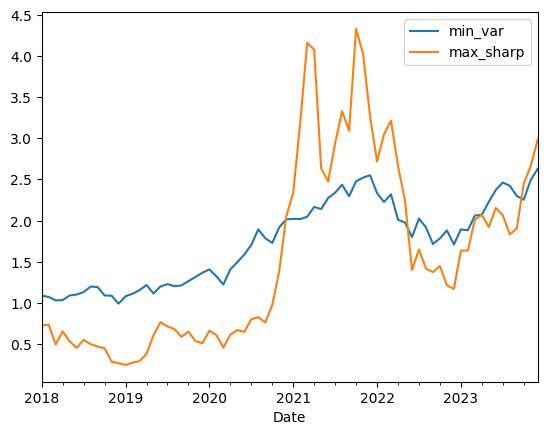

In [12]:
cum.plot()